In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
# Point generation with noise
def gen_data(num_samples, noise=0):
    points = []
    labels = []

    for i in range(num_samples):
        x = np.random.uniform()
        y = np.random.uniform()

        nx = np.random.uniform(low=-noise/100, high=noise/100)
        ny = np.random.uniform(low=-noise/100, high=noise/100)

        if(-0.7*x-y+0.6 < 0 and -0.8*x-y+1.1 > 0 and 2.5*x-y > 0 and 5*x-y-3 < 0):
            if noise > 0:
                points.append([x+nx, y+ny, 0])
                labels.append(0)
            else:
                points.append([x, y, 0])
                labels.append(0)
        else:
            if noise > 0:
                points.append([x+nx, y+ny, 1])
                labels.append(1)
            else:
                points.append([x, y, 1])
                labels.append(1)

    return points, labels

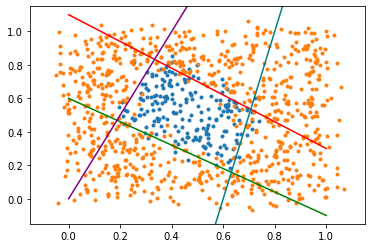

In [ ]:
points, labels = gen_data(1000, 7)


plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

# plot lines
x = torch.linspace(0,1)
plt.plot(x, -(0.7*x-0.6), 'green')  # y = -0.7*x+0.6 => -0.7*x-y+0.6 >0
plt.plot(x, -(0.8*x-1.1), 'red')    # y = -0.8*x+1.1 => -0.8*x-y+1.1 < 0 
plt.plot(x, (2.5*x), 'purple')      # y = 2.5*x => 2.5*x-y < 0
plt.plot(x, (5*x-3), 'teal')        # y = 5*x-3 => 5*x-y-3 > 0

plt.ylim(-0.15, 1.15)
plt.xlim(-0.15, 1.15)
plt.show()

In [ ]:
trainX = torch.Tensor([[i[0],i[1]] for i in points]).float()
trainY = torch.Tensor([[i[2]] for i in points]).float()

In [ ]:
# implement class wrapper for squashing activation function
class Squashing(nn.Module):
    def __init__(self, learnable=True, beta=0.1):
        '''
        Init method.
        '''
        super(Squashing, self).__init__()

        # initialize fix parameters
        self.alpha = 0.5
        self.lam = 1.0

        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta 1:", self.beta.data.item())
        global betas
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )
    

In [ ]:
# implement class wrapper for swish activation function
class Swish(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super(Swish, self).__init__()

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        return x * torch.sigmoid(x)

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net,self).__init__()

#         self.g1_layer = nn.Linear(in_features=2, out_features=1)
#         self.g2_layer = nn.Linear(in_features=2, out_features=1)
#         self.g3_layer = nn.Linear(in_features=2, out_features=1)
#         self.g4_layer = nn.Linear(in_features=2, out_features=1)

#         self.undg1g2 = nn.Linear(in_features=2, out_features=1)
#         self.undg3g4 = nn.Linear(in_features=2, out_features=1)
#         self.undgout = nn.Linear(in_features=2, out_features=1)
        
#         self.undg1g2.bias.requires_grad  = False
#         self.undg1g2.weight.requires_grad = False
#         self.undg3g4.bias.requires_grad  = False
#         self.undg3g4.weight.requires_grad = False
#         self.undgout.bias.requires_grad  = False
#         self.undgout.weight.requires_grad = False
  
#         with torch.no_grad():
#             self.undg1g2.bias.fill_(-1.0)
#             self.undg1g2.weight.fill_(1.0)
#             self.undg3g4.bias.fill_(-1.0)
#             self.undg3g4.weight.fill_(1.0)
#             self.undgout.bias.fill_(-1.0)
#             self.undgout.weight.fill_(1.0)

#         self.activation = SquashingFunction()
        
#     #This must be implemented
#     def forward(self, x):
        
#         g1 = self.g1_layer(x)
#         g1 = self.activation(g1)

#         g2 = self.g2_layer(x)
#         g2 = self.activation(g2)
        
#         g3 = self.g3_layer(x)
#         g3 = self.activation(g3)
        
#         g4 = self.g4_layer(x)
#         g4 = self.activation(g4)
        
#         g1g2 = self.undg1g2(torch.cat((g1, g2), 1))
#         g1g2 = self.activation(g1g2)
        
#         g3g4 = self.undg3g4(torch.cat((g3, g4), 1))
#         g3g4 = self.activation(g3g4)

#         z = self.undgout(torch.cat((g1g2, g3g4), 1))
#         z = self.activation(z)

#         return z

In [ ]:
class Net4(nn.Module):
    def __init__(self, activation = 'squashing'):
        super(Net4,self).__init__()

        self.g1_layer = nn.Linear(in_features=2, out_features=1)
        self.g2_layer = nn.Linear(in_features=2, out_features=1)
        self.g3_layer = nn.Linear(in_features=2, out_features=1)
        self.g4_layer = nn.Linear(in_features=2, out_features=1)

        self.undgout = nn.Linear(in_features=4, out_features=1)
        
        self.undgout.bias.requires_grad  = False
        self.undgout.weight.requires_grad = False
  
        with torch.no_grad():
            self.undgout.bias.fill_(-3.0)
            self.undgout.weight.fill_(1.0)
        
        if activation == 'relu':
            print("relu")
            self.activation = nn.ReLU()
            self.activation1 = nn.ReLU()
            
        if activation == 'sigmoid':
            print("sigmoid")
            self.activation = nn.Sigmoid()
            self.activation1 = nn.Sigmoid()
            
        if activation == 'swish':
            print("swish")
            self.activation = Swish()
            self.activation1 = Swish()

        
        if activation == "tanh":
            print("tanh")
            self.activation = nn.Tanh()
            self.activation1 = nn.Tanh()
            
        if activation == 'squashing':
            print("squashing")
            self.activation_g1 = Squashing()
            self.activation_g2 = Squashing()
            self.activation_g3 = Squashing()
            self.activation_g4 = Squashing()
            self.activation_and = Squashing()
            
        if (activation == 'squashing-nl'):
            print("squashing-nl")
            self.activation = Squashing(False, beta=1)
            self.activation1 = Squashing(False, beta=-1)
        
        
    #This must be implemented
    def forward(self, x):
        global beta_and
        global beta_g1
        global beta_g2
        global beta_g3
        global beta_g4
        
        g1 = self.g1_layer(x)
        g1 = self.activation_g1(g1)
        beta_g1 = betas

        g2 = self.g2_layer(x)
        g2 = self.activation_g2(g2)
        beta_g2 = betas
        
        g3 = self.g3_layer(x)
        g3 = self.activation_g3(g3)
        beta_g3 = betas

        g4 = self.g4_layer(x)
        g4 = self.activation_g4(g4)
        beta_g4 = betas

        z = self.undgout(torch.cat((g1,g2,g3,g4), 1))
        z = self.activation_and(z)
        beta_and = betas

        return z


squashing
Epoch: 0
G1-Weight: tensor([[-0.5161,  0.6693]]) G1-Bias: tensor([0.4441])
G2-Weight: tensor([[-0.5541,  0.5613]]) G2-Bias: tensor([-0.3046])
G3-Weight: tensor([[0.6364, 0.1428]]) G1-Bias: tensor([0.2977])
G4-Weight: tensor([[ 0.3610, -0.1127]]) G2-Bias: tensor([0.4255])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.5161 * x + 0.4441) / 0.6693)
z2: y = -((-0.5541 * x + -0.3046) / 0.5613)
z3: y = -((0.6364 * x + 0.2977) / 0.1428)
z4: y = -((0.361 * x + 0.4255) / -0.1127)


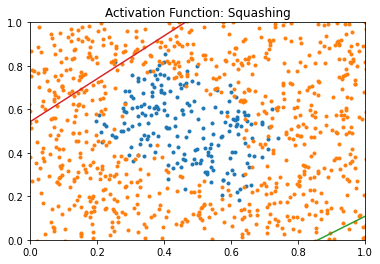

Epoch: 100
G1-Weight: tensor([[0.3977, 0.8158]]) G1-Bias: tensor([1.2059])
G2-Weight: tensor([[-0.8951,  0.4691]]) G2-Bias: tensor([-0.6998])
G3-Weight: tensor([[0.4714, 0.2040]]) G1-Bias: tensor([0.2241])
G4-Weight: tensor([[-0.2877,  0.0111]]) G2-Bias: tensor([0.1118])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.3977 * x + 1.2059) / 0.8158)
z2: y = -((-0.8951 * x + -0.6998) / 0.4691)
z3: y = -((0.4714 * x + 0.2241) / 0.204)
z4: y = -((-0.2877 * x + 0.1118) / 0.0111)


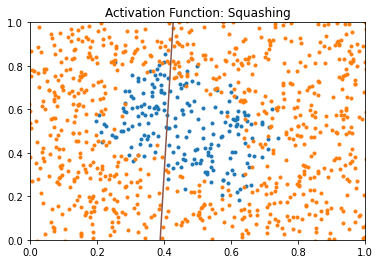

Epoch: 200
G1-Weight: tensor([[0.5725, 0.3422]]) G1-Bias: tensor([1.2527])
G2-Weight: tensor([[-0.6213,  0.6315]]) G2-Bias: tensor([-0.6194])
G3-Weight: tensor([[0.7456, 0.0126]]) G1-Bias: tensor([0.2717])
G4-Weight: tensor([[-0.7967,  0.4425]]) G2-Bias: tensor([0.0409])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.5725 * x + 1.2527) / 0.3422)
z2: y = -((-0.6213 * x + -0.6194) / 0.6315)
z3: y = -((0.7456 * x + 0.2717) / 0.0126)
z4: y = -((-0.7967 * x + 0.0409) / 0.4425)


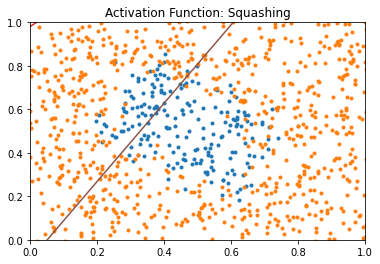

Epoch: 300
G1-Weight: tensor([[0.5456, 0.1699]]) G1-Bias: tensor([1.2898])
G2-Weight: tensor([[-0.4262,  0.4548]]) G2-Bias: tensor([-0.6147])
G3-Weight: tensor([[ 1.0350, -0.2651]]) G1-Bias: tensor([0.3135])
G4-Weight: tensor([[-0.7072,  0.5959]]) G2-Bias: tensor([0.0932])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.5456 * x + 1.2898) / 0.1699)
z2: y = -((-0.4262 * x + -0.6147) / 0.4548)
z3: y = -((1.035 * x + 0.3135) / -0.2651)
z4: y = -((-0.7072 * x + 0.0932) / 0.5959)


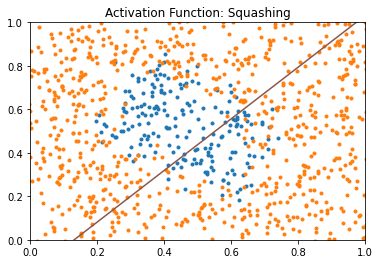

Epoch: 400
G1-Weight: tensor([[0.4674, 0.1339]]) G1-Bias: tensor([1.3474])
G2-Weight: tensor([[-0.3073,  0.1752]]) G2-Bias: tensor([-0.6888])
G3-Weight: tensor([[ 1.1217, -0.7423]]) G1-Bias: tensor([-0.0004])
G4-Weight: tensor([[-0.6426,  0.4776]]) G2-Bias: tensor([0.0888])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.4674 * x + 1.3474) / 0.1339)
z2: y = -((-0.3073 * x + -0.6888) / 0.1752)
z3: y = -((1.1217 * x + -0.0004) / -0.7423)
z4: y = -((-0.6426 * x + 0.0888) / 0.4776)


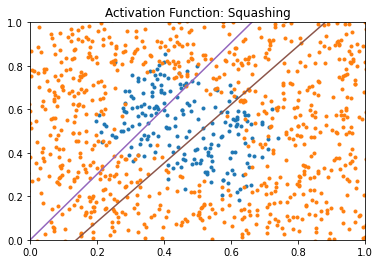

Epoch: 500
G1-Weight: tensor([[-0.8222,  0.7064]]) G1-Bias: tensor([1.2234])
G2-Weight: tensor([[ 1.0934, -0.6179]]) G2-Bias: tensor([-0.5048])
G3-Weight: tensor([[ 5.8174, -2.9891]]) G1-Bias: tensor([-2.3005])
G4-Weight: tensor([[ 1.2913, -0.8723]]) G2-Bias: tensor([0.1924])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8222 * x + 1.2234) / 0.7064)
z2: y = -((1.0934 * x + -0.5048) / -0.6179)
z3: y = -((5.8174 * x + -2.3005) / -2.9891)
z4: y = -((1.2913 * x + 0.1924) / -0.8723)


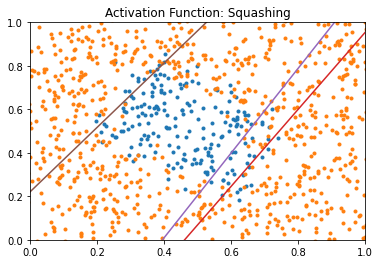

Epoch: 600
G1-Weight: tensor([[-0.8860, -0.0805]]) G1-Bias: tensor([1.5138])
G2-Weight: tensor([[1.5358, 0.8805]]) G2-Bias: tensor([0.6342])
G3-Weight: tensor([[8.4171, 1.0113]]) G1-Bias: tensor([-5.6846])
G4-Weight: tensor([[7.3881, 1.1352]]) G2-Bias: tensor([-1.9676])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.886 * x + 1.5138) / -0.0805)
z2: y = -((1.5358 * x + 0.6342) / 0.8805)
z3: y = -((8.4171 * x + -5.6846) / 1.0113)
z4: y = -((7.3881 * x + -1.9676) / 1.1352)


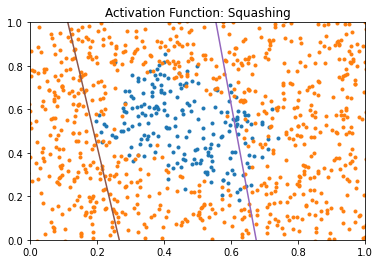

Epoch: 700
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


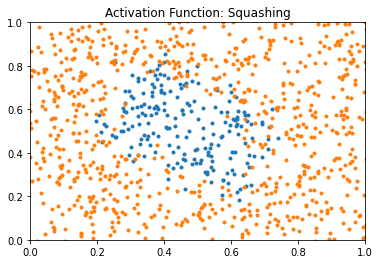

Epoch: 800
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


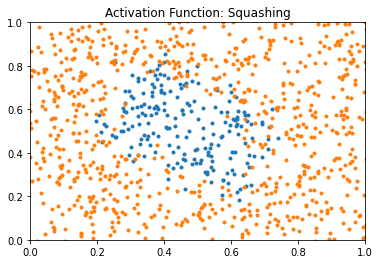

Epoch: 900
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


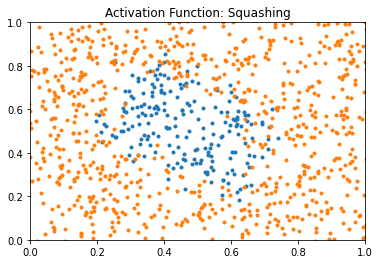

Epoch: 1000
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


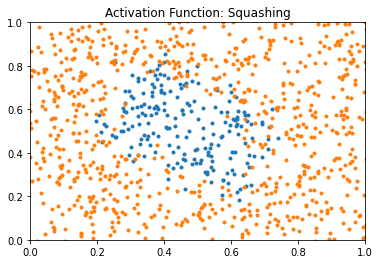

Epoch: 1100
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


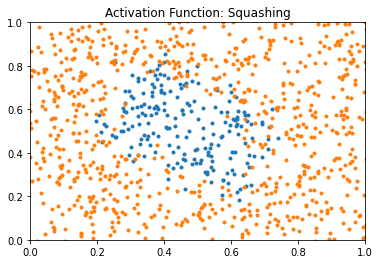

Epoch: 1200
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


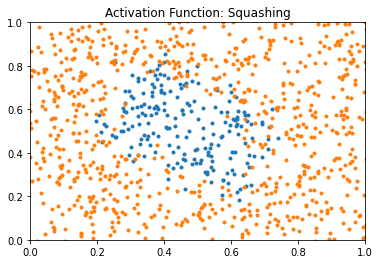

Epoch: 1300
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


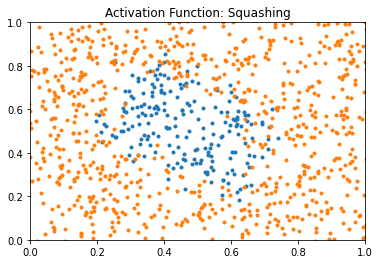

Epoch: 1400
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


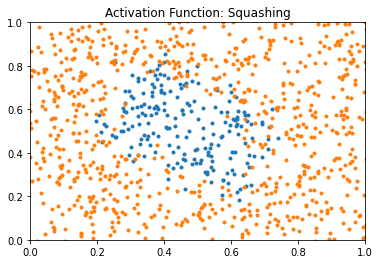

Epoch: 1500
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


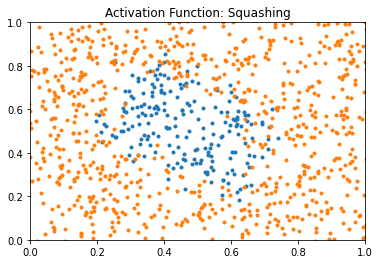

Epoch: 1600
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


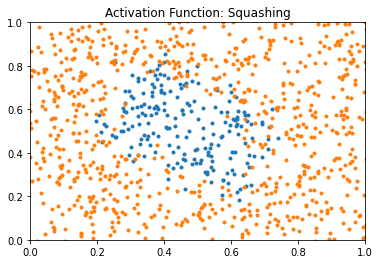

Epoch: 1700
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


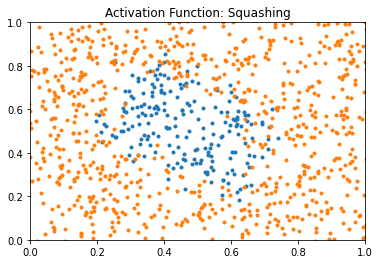

Epoch: 1800
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


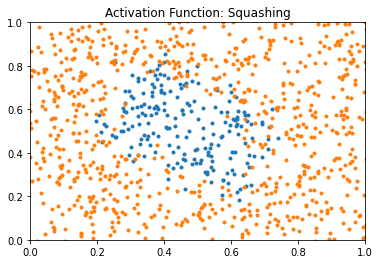

Epoch: 1900
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


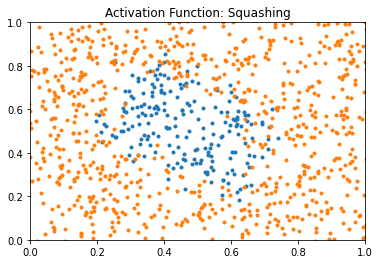

Epoch: 2000
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


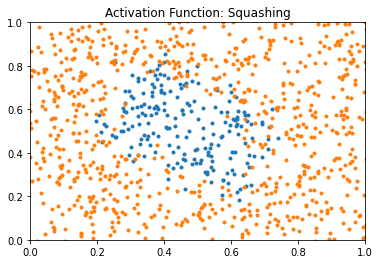

Epoch: 2100
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


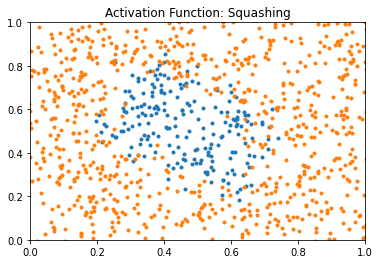

Epoch: 2200
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


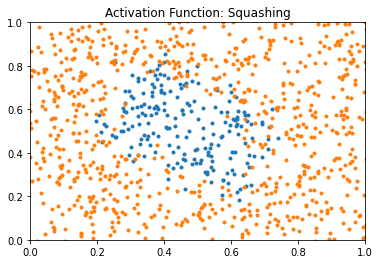

Epoch: 2300
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


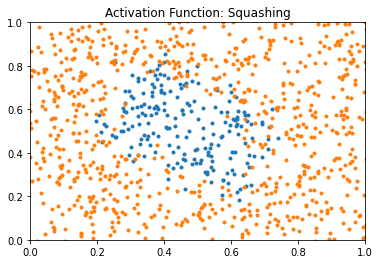

Epoch: 2400
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


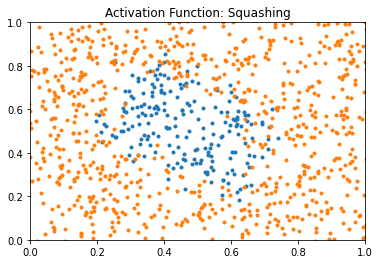

Epoch: 2500
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


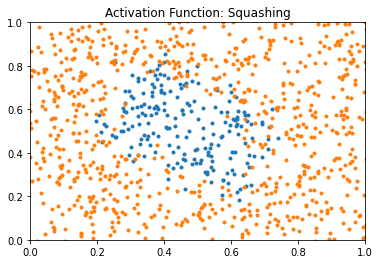

Epoch: 2600
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


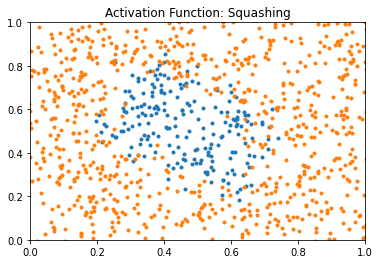

Epoch: 2700
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


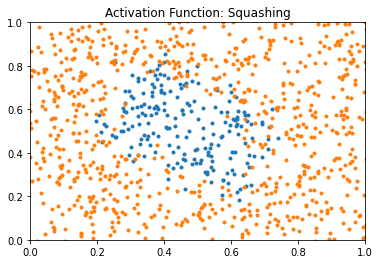

Epoch: 2800
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


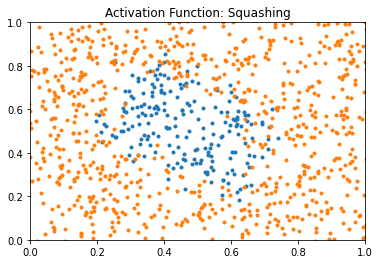

Epoch: 2900
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


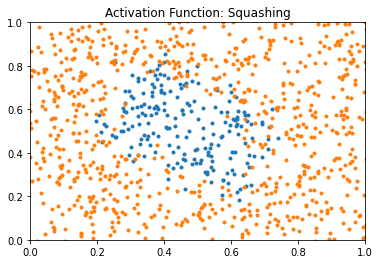

Epoch: 3000
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


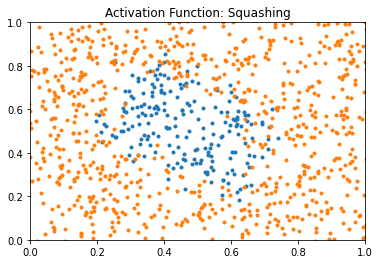

Epoch: 3100
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


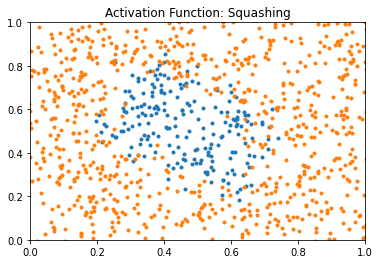

Epoch: 3200
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


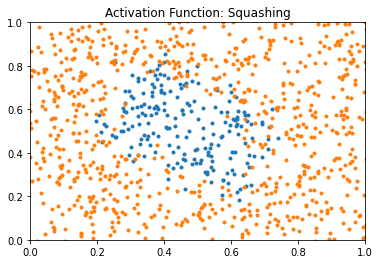

Epoch: 3300
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


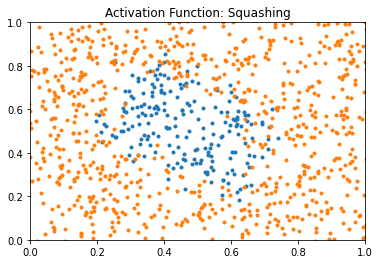

Epoch: 3400
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


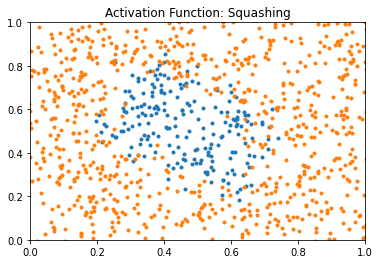

Epoch: 3500
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


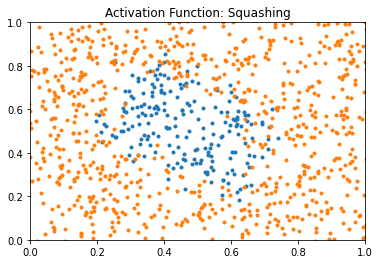

Epoch: 3600
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


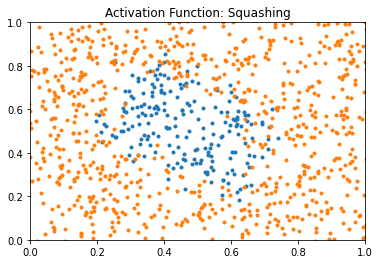

Epoch: 3700
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


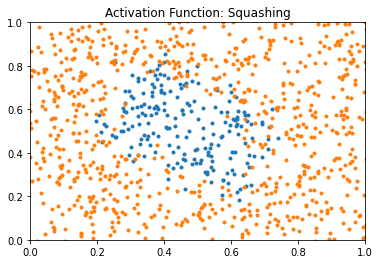

Epoch: 3800
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


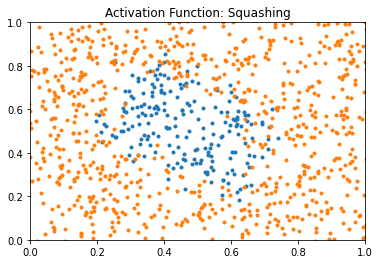

Epoch: 3900
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


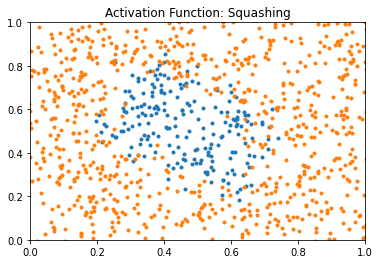

Epoch: 4000
G1-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G2-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
G3-Weight: tensor([[nan, nan]]) G1-Bias: tensor([nan])
G4-Weight: tensor([[nan, nan]]) G2-Bias: tensor([nan])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((nan * x + nan) / nan)
z2: y = -((nan * x + nan) / nan)
z3: y = -((nan * x + nan) / nan)
z4: y = -((nan * x + nan) / nan)


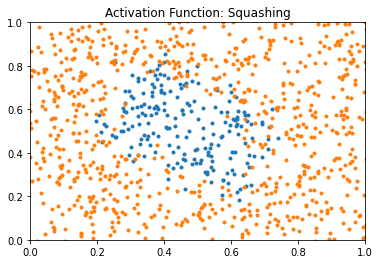

In [ ]:
network = Net4(activation='squashing')

optimizer = optim.Adam(network.parameters(), lr=0.023)
criterion = nn.MSELoss()

x = torch.linspace(-3, 3)

beta_g1_arr = []
beta_g2_arr = []
beta_g3_arr = []
beta_g4_arr = []

beta_and_arr = []
loss_arr = []
running_loss = 0

for epoch in range(4001):
    preds = network(trainX)
    #print(preds)
    loss = criterion(preds, trainY) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Calculate Gradient
    optimizer.step() # Update Weights

    beta_g1_arr.append(beta_g1)
    beta_g2_arr.append(beta_g2)
    beta_g3_arr.append(beta_g3)
    beta_g4_arr.append(beta_g4)

    beta_and_arr.append(beta_and)
    loss_arr.append(loss.item())
    running_loss += loss.item()

    if epoch %100 == 0:
        print("Epoch:", epoch)
        print("G1-Weight:", network.g1_layer.weight.data, "G1-Bias:", network.g1_layer.bias.data)
        print("G2-Weight:", network.g2_layer.weight.data, "G2-Bias:", network.g2_layer.bias.data)
        print("G3-Weight:", network.g3_layer.weight.data, "G1-Bias:", network.g3_layer.bias.data)
        print("G4-Weight:", network.g4_layer.weight.data, "G2-Bias:", network.g4_layer.bias.data)

        #print("AND-Weight G1G2:", network.undg1g2.weight.data, "AND-Bias:", network.undg1g2.bias.data)
        #print("AND-Weight G3G4:", network.undg3g4.weight.data, "AND-Bias:", network.undg3g4.bias.data)
        print("AND-Weight GOut:", network.undgout.weight.data, "AND-Bias:", network.undgout.bias.data)

        y1 = -((network.g1_layer.weight.squeeze()[0] * x + network.g1_layer.bias[0]) / network.g1_layer.weight.squeeze()[1])
        y2 = -((network.g2_layer.weight.squeeze()[0] * x + network.g2_layer.bias[0]) / network.g2_layer.weight.squeeze()[1])
        y3 = -((network.g3_layer.weight.squeeze()[0] * x + network.g3_layer.bias[0]) / network.g3_layer.weight.squeeze()[1])
        y4 = -((network.g4_layer.weight.squeeze()[0] * x + network.g4_layer.bias[0]) / network.g4_layer.weight.squeeze()[1])
        print(f'z1: y = -(({round(float(network.g1_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g1_layer.bias[0]),4)}) / {round(float(network.g1_layer.weight.squeeze()[1]), 4)})')
        print(f'z2: y = -(({round(float(network.g2_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g2_layer.bias[0]),4)}) / {round(float(network.g2_layer.weight.squeeze()[1]), 4)})')
        print(f'z3: y = -(({round(float(network.g3_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g3_layer.bias[0]),4)}) / {round(float(network.g3_layer.weight.squeeze()[1]), 4)})')
        print(f'z4: y = -(({round(float(network.g4_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g4_layer.bias[0]),4)}) / {round(float(network.g4_layer.weight.squeeze()[1]), 4)})')
        
    
        plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
        plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

        plt.plot(x.numpy(), y1.detach().numpy(), '-')
        plt.plot(x.numpy(), y2.detach().numpy(), '-')
        plt.plot(x.numpy(), y3.detach().numpy(), '-')
        plt.plot(x.numpy(), y4.detach().numpy(), '-')
        #plt.title(f'Epoch: {epoch}; Learning Rate: 0.02\n β Linear Layer: {round(betagerade,4)} ; β AND Operator: {round(betaand,4)}')
        plt.title(f'Activation Function: Squashing')
        #print("Beta:", betas)
        #print("Beta-Gerade:", betagerade)
        #print("Beta-AND:", betaand)
        #print("Loss:", running_loss/1000)
        plt.ylim(0,1)
        plt.xlim(0,1)
    plt.show()

<function matplotlib.pyplot.show>

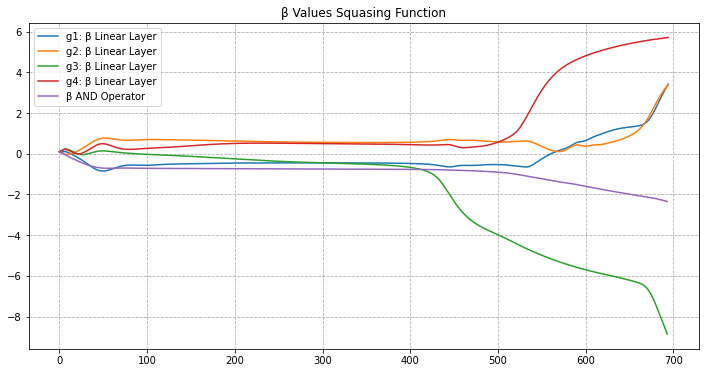

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(beta_g1_arr, label='g1: β Linear Layer')
plt.plot(beta_g2_arr, label='g2: β Linear Layer')
plt.plot(beta_g3_arr, label='g3: β Linear Layer')
plt.plot(beta_g4_arr, label='g4: β Linear Layer')

plt.plot(beta_and_arr, label='β AND Operator')
plt.legend(loc=2)
plt.grid(True, axis='both', linestyle='--')
plt.title('β Values Squasing Function')
plt.show

<function matplotlib.pyplot.show>

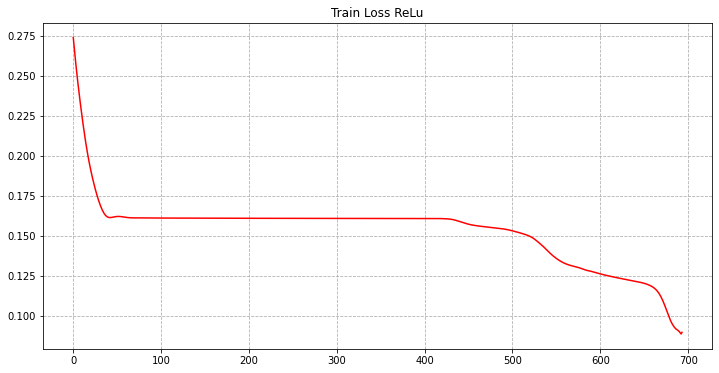

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Train Loss ReLu')
plt.plot(loss_arr, label='Loss', color='r')
plt.grid(True, axis='both', linestyle='--')
plt.show